https://www.kaggle.com/code/geekysaint/solving-mnist-using-pytorch

In [45]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

import matplotlib.pyplot as plt

In [46]:
dataset = MNIST(root='data/', download=True)
print(len(dataset))

60000


Label: 4


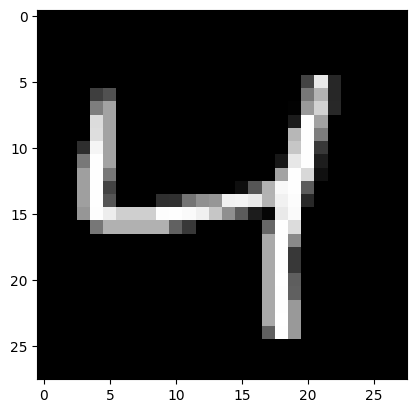

In [47]:
image, label = dataset[2]
plt.imshow(image, cmap='gray')
print(f"Label: {label}")

In [48]:
mnist_dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())
print(len(mnist_dataset))

60000


In [49]:
image_tensor, label = mnist_dataset[0]
print(image_tensor.shape)

torch.Size([1, 28, 28])


tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])


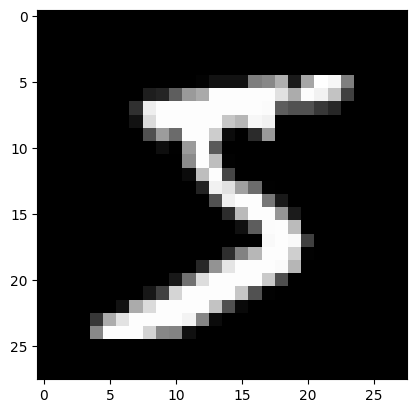

In [50]:
print(image_tensor[:, 10:15, 10:15])
plt.imshow(image_tensor[0, : , :],cmap = 'gray')


In [51]:
train_data, validation_data = random_split(mnist_dataset, [50000, 10000])

print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")

batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)





Train data size: 50000
Validation data size: 10000


In [52]:
input_size = 28 * 28
num_classes = 10

model = nn.Linear(input_size, num_classes)
print(model)

Linear(in_features=784, out_features=10, bias=True)


In [53]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return(model.validation_epoch_end(outputs))


In [54]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()
print(model)
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())


MnistModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)
torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0117, -0.0158,  0.0110,  ...,  0.0114, -0.0207, -0.0127],
         [-0.0177, -0.0294, -0.0349,  ..., -0.0043,  0.0083, -0.0254],
         [ 0.0347,  0.0029, -0.0256,  ...,  0.0260, -0.0170, -0.0039],
         ...,
         [ 0.0218, -0.0200,  0.0078,  ..., -0.0064,  0.0236,  0.0133],
         [ 0.0188,  0.0015,  0.0216,  ..., -0.0204, -0.0014, -0.0073],
         [ 0.0181, -0.0316,  0.0219,  ..., -0.0037, -0.0272, -0.0214]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0178, -0.0346, -0.0276,  0.0065, -0.0232, -0.0302,  0.0338,  0.0099,
          0.0020, -0.0054], requires_grad=True)]

In [55]:
history = []
epochs = 10
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
for epoch in range(epochs):
    
    ## Training Phas
    for batch in train_loader:
        loss = model.training_step(batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    ## Validation phase
    result = evaluate(model, validation_loader)
    model.epoch_end(epoch, result)
    history.append(result)
    print(f"Epoch {epoch} : Validation Loss: {result['val_loss']}, Validation Accuracy: {result['val_acc']}")
print(history)

Epoch [0], val_loss: 1.9533, val_acc: 0.6184
Epoch 0 : Validation Loss: 1.953277587890625, Validation Accuracy: 0.618374228477478
Epoch [1], val_loss: 1.6836, val_acc: 0.7181
Epoch 1 : Validation Loss: 1.6836470365524292, Validation Accuracy: 0.7180577516555786
Epoch [2], val_loss: 1.4825, val_acc: 0.7539
Epoch 2 : Validation Loss: 1.4824851751327515, Validation Accuracy: 0.7538567781448364
Epoch [3], val_loss: 1.3306, val_acc: 0.7770
Epoch 3 : Validation Loss: 1.330550193786621, Validation Accuracy: 0.7769976258277893
Epoch [4], val_loss: 1.2135, val_acc: 0.7931
Epoch 4 : Validation Loss: 1.2135156393051147, Validation Accuracy: 0.793117105960846
Epoch [5], val_loss: 1.1215, val_acc: 0.8045
Epoch 5 : Validation Loss: 1.1215462684631348, Validation Accuracy: 0.8044897317886353
Epoch [6], val_loss: 1.0478, val_acc: 0.8113
Epoch 6 : Validation Loss: 1.0477912425994873, Validation Accuracy: 0.811313271522522
Epoch [7], val_loss: 0.9874, val_acc: 0.8192
Epoch 7 : Validation Loss: 0.9874014

Text(0.5, 1.0, 'Accuracy Vs. No. of epochs')

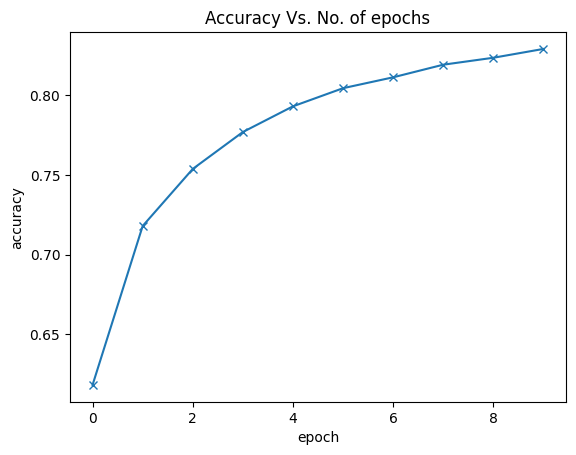

In [56]:
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Vs. No. of epochs')

In [57]:
torch.save(model.state_dict(), 'mnist-logistic.pth')


In [ ]:
## Define the test dataset
test_dataset = MNIST(root = 'data/', train = False, transform = transforms.ToTensor())

In [61]:
test_loader = DataLoader(test_dataset, batch_size = 256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.8919254541397095, 'val_acc': 0.828828752040863}